# Introduction to Deep Reinforcement Learning *via* the Arcade Learning Environment

## Introduction
### Background
A quick recap on reinforcement learning and the notations we will adopt here : we address the problem of an **agent** learning to act in an **environment** in order to maximize a **reward** signal.


At each time step, the environment provides an observation $s_t \in S$, the agent responds by selecting an action $a_t \in A$ and then the environment provides a reward $r_{t+1}$ and the next state $s_{t+1}$ with a discount factor $\gamma \in [0, 1]$.
We assume that this system is a Markov Decision Process e.g. the state of the system at the time step $t+1$ only depends on the state and the action chose at the time step $t$.


The goal of RL is to find a policy $\pi$ (e.g. a probability distribution over actions for each state) that maximize the expected discounted return $G_t = \sum_{k=0}^{+\infty}{\gamma^k R_{t+k+1}}$ over an episode in the environment.

To do so, we learn an estimate of the **Q-Value function** $Q_\pi(s_t, a_t) = E_\pi[G_t|s_t, a_t]$ which is equal to the expected reward an agent will receive starting from a state $s_t$ and action $a_t$ and then acting under policy $\pi$. Once this Q-Value function is known, an optimal policy is trivial : $\pi(s_t) = max_{a \in A}{Q(s_t, a)}$.

Let's also define the **Value function** $V_\pi(s_t) = E_\pi[G_t|s_t]$ the expected discounted reward obtained following a policy $\pi$ starting from a state $s_t$.


*For more details, see the [wikipedia page on MDPs][wikiMDP].*



### DQN Algorithm
Theorically, some methods exist to compute the Q-Value function, such as tabular Q-Learning. The idea is to start from a random guess of the Q-Value of each pair (state, action) and iteratively apply [Bellman Equation][BellEq] until it converges toward the real value of the function *(see [this post by Arthur Juliani][JulianiPost] to get an example)*.


But this method is only appliable on very few problems with tiny state and action spaces, and usual problems generally have nearly infinite large state space, and even if the idea is not bad, the tabular approach cannot work on them.


Deep Reinforcement Learning is an efficient method to solve such problems. The idea is to approximate the Q-Value function with a deep neural network trained by gradient descent to then derive a well performing policy from it.
It was successfully implemented for the first time in 2015 [[Mnih et al][DQN]] as DQN by combining the use of convolutional nets to efficiently processes the raw frames fed as input to the network and of a replay memory buffer not to learn only on immediate rewards.


The optimization by gradient descent is realized wrt to the loss on a randomly chosen time step picked from the replay memory $$(R_t + \gamma_{t+1} max_aQ_\bar{\theta}(s_{t+1}, a) - Q\theta(s_t, a_t))^2$$ with $Q_\bar{\theta}$ the *online network* (the network used to select the action) and $Q_\theta$ the *target network* (a copy of the network periodically updated to stabilize the learning).


DQN was the first concrete example of successful reinforcement learning algorithm, and it opened the way to many researches and improvements since 2015. In this notebook, I will present three modified versions of DQN that has lead to improvements or that extended the application domain :
* A3C : an asynchronous version that allows parallelism
* DDPG : a continuous version
* Rainbow DQN : an improved version of DQN, one of the most efficient algorithm of Deep RL today


[wikiMDP]: https://en.wikipedia.org/wiki/Markov_decision_process
[BellEq]: https://en.wikipedia.org/wiki/Bellman_equation#Example
[JulianiPost]: https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0
[DQN]: https://www.nature.com/articles/nature14236

## Asynchronous Advantage Actor-Critic (A3C)

### Concept
Presented in 2016 [[Mnih et al. again](https://arxiv.org/pdf/1602.01783.pdf)], A3C is quite different from regular DQN : it's an Actor-Critic. First, let's debunk the name of the algorithm to understand it better :
+ **Asynchronous :** Asynchronous algorithm is a great family of algos designed to run on parallel architecture to speed the learning up. The main idea is instead of having only one agent interacting with an environment, an asynchronous algo creates a global network and many workers on parallel threads with each their own environment and their own neural network. Then, during an episode, each agent copies the weights of the global network, then interacts with it's own environment and apply a gradient descent on the weight of the global network.

 This has two main advantages :
  - the parallelism of today hardware allows to run tens or even hundreds of workers on different thread, and so to maximize the work done in a given time
  - each worker being independent of the others, they collect a lot of various experience and assure a better exploration of the state space, removing the necessity to have a replay memory buffer


+ **Actor-Critic :** Instead of just estimating the Q-Value function and then inducing a policy by acting greedily with respect to the action Q-Values, in Actor-Critic algorithms, the network estimate both the Value $V$ function and a policy $\pi$. The value estimator is called the **critic** and the policy estimator the **actor**.



+ **Advantage :** We define advantage as the difference between the Q-Value and the Value of a given state and action $A(s, a) = Q(s, a) - V(s)$ : it represents how much better an action is than expected. During a gradient descent, the updates usually use discounted reward to tell the quality of a taken action, but one way to be more efficient is instead to use an advantage estimate to get how much better it is than average.

 We can estimate this advantage quite easily because $V(s_t)$ is the output of our network and $Q(s_t, a_t)$ can be estimated by the discounted reward $R_t = \sum_{k=0}^{+\infty}{\gamma^k r_{t+k}}$ : $$A_{est}(s_t, a_t) = R_t - V(s_t)$$
 
![alt text](./Images/A3C.png "Architecture of an A3C Network")

Additionnaly, we add a LSTM layer to the classic A3C algorithm for better results (see [Chris Olah's blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) for more details)

### Implementation
*This code can be found in ../A3C/Discrete*

Let's now see an actual implementation of the A3C algorithm applied to a simple Atari 2600 game : Pong.
First, the general outline of the code architecture :
- **NetworkArchitecture.py** : defines a class that builds a neural network with convolution and LSTM layers
- **Network.py** : defines a class that sets up a model (an instance of NetworkArchitecture) and Tensorflow operations to compute and apply gradients on the network weights
- **Environment.py** : wrapper for [gym environments](https://github.com/openai/gym)
- **Agent.py** : defines a worker that contains a local network and a local environment and that can interact within this environment to get experiences and train the global network
- **main.py** : the main program that creates a global network and many workers, and run them on different threads
- **parameters.py** : contains every important parameter that can be modified in the algorithm
- **Displayer.py**, **Saver.py** : defines visualisation and saving tools


Now, let's analyze more precisely the main lines of the code.

#### Network

First of all, let's build a convolutional neural network architecture made of two convolution layers followed by a fully connected, and then a LSTM network :

*From NetworkArchitecture.py*

In [8]:
import tensorflow as tf
import numpy as np

LSTM_CELLS = 256

class NetworkArchitecture:

    def __init__(self, state_size):
        self.state_size = state_size

    def build_conv(self):
        """Define a succesion of convolutional layers followed by a fully
        connected layer and return the input placeholder"""

        # Placeholder for the input states (e.g the raw pixel frames)
        self.inputs = tf.placeholder(tf.float32, [None, *self.state_size],
                                     name='Input_state')

        with tf.variable_scope('Convolutional_Layers'):
            self.conv1 = tf.layers.conv2d(inputs=self.inputs,
                                          filters=32,
                                          kernel_size=[8, 8],
                                          strides=[4, 4],
                                          padding='valid',
                                          activation=tf.nn.relu)
            self.conv2 = tf.layers.conv2d(inputs=self.conv1,
                                          filters=64,
                                          kernel_size=[4, 4],
                                          strides=[2, 2],
                                          padding='valid',
                                          activation=tf.nn.relu)

        # Flatten the output
        flat_conv2 = tf.layers.flatten(self.conv2)
        self.hidden = tf.layers.dense(flat_conv2, 256, activation=tf.nn.elu)
        return self.inputs

    def build_lstm(self):

        with tf.variable_scope('LSTM'):
            # New LSTM Network with 256 cells
            lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(LSTM_CELLS)
            c_size = lstm_cell.state_size.c
            h_size = lstm_cell.state_size.h

            # Initial cell state
            c_init = np.zeros((1, c_size), np.float32)
            h_init = np.zeros((1, h_size), np.float32)
            self.lstm_state_init = [c_init, h_init]

            # Input state
            c_in = tf.placeholder(tf.float32, [1, c_size])
            h_in = tf.placeholder(tf.float32, [1, h_size])

            # tf.nn.dynamic_rnn expects inputs of shape
            # [batch_size, time, features], but the shape of hidden is
            # [batch_size, features]. We want the batch_size dimension to
            # be treated as the time dimension, so the input is redundantly
            # expanded to [1, batch_size, features].
            # The LSTM layer will assume it has 1 batch with a time
            # dimension of length batch_size.
            lstm_input = tf.expand_dims(self.hidden, [0])
            step_size = tf.shape(self.inputs)[:1]
            state_in = tf.nn.rnn_cell.LSTMStateTuple(c_in, h_in)

            # Unroll the LSTM cells
            lstm_output, lstm_state = tf.nn.dynamic_rnn(lstm_cell,
                                                        lstm_input,
                                                        step_size,
                                                        state_in)
            lstm_c, lstm_h = lstm_state
            self.state_out = (lstm_c[:1, :], lstm_h[:1, :])
            self.output = tf.reshape(lstm_output, [-1, LSTM_CELLS])
            return (c_in, h_in)

    def return_output(self):
        """Return the state of the LSTM cells and their output"""
        return self.state_out, self.output

Now that we have the architecture of a neural network, we can build a complete network by appending two fully connected layers after the LSTM output to estimate the Value function and the policy and by defining the tensorflow operations for gradient descent.

*From Network.py*

In [36]:
import tensorflow as tf
import numpy as np

MAX_GRADIENT_NORM = 40.0

class Network:

    def __init__(self, state_size, action_size, scope):

        with tf.variable_scope(scope):
            self.state_size = state_size
            self.action_size = action_size

            # Creation of the model
            self.model = NetworkArchitecture(self.state_size)

            # We create the convolution layers and get the input placeholder
            self.inputs = self.model.build_conv()

            # We create the LSTM network and get the input placeholder
            self.state_in = self.model.build_lstm()

            self.lstm_state_init = self.model.lstm_state_init
            
            # We get the output of the LSTM network and add two layers to estimate
            # the value function and the policy
            self.state_out, model_output = self.model.return_output()

            self.policy = tf.layers.dense(model_output, action_size, activation=tf.nn.softmax)
            self.value = tf.layers.dense(model_output, 1, activation=None)

        # If it is not the global network
        if scope != 'global':
            self.actions = tf.placeholder(tf.int32, [None], 'Action')
            self.actions_onehot = tf.one_hot(self.actions, self.action_size, dtype=tf.float32)
            self.advantages = tf.placeholder(tf.float32, [None], 'Advantage')
            self.discounted_reward = tf.placeholder(tf.float32, [None], 'Discounted_Reward')
            
            self.responsible_outputs = tf.reduce_sum(self.policy * self.actions_onehot, [1])
            self.responsible_outputs = tf.clip_by_value(self.responsible_outputs, 1e-20, 1)  # Prevent from log(0)

            # Estimate the policy loss and regularize it by adding uncertainty (= subtracting entropy)
            self.policy_loss = -tf.reduce_sum(tf.multiply(
                tf.log(self.responsible_outputs), self.advantages))
            self.entropy = -tf.reduce_sum(self.policy * tf.log(self.policy))

            # Estimate the value loss using the sum of squared errors.
            self.value_loss = tf.reduce_sum(tf.square(self.advantages))

            # Estimate the final loss.
            self.loss = self.policy_loss + 0.5 * self.value_loss - 0.01 * self.entropy

            # Fetch and clip the gradients of the local network.
            local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
            gradients = tf.gradients(self.loss, local_vars)
            clipped_gradients, self.grad_norm = tf.clip_by_global_norm(gradients, MAX_GRADIENT_NORM)

            # Apply gradients to global network
            global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
            optimizer = tf.train.AdamOptimizer(parameters.LEARNING_RATE)
            grads_and_vars = zip(clipped_gradients, global_vars)
            self.apply_grads = optimizer.apply_gradients(grads_and_vars)


### Results

### Notes

## Deep Deterministic Policy Gradient (DDPG)

### Concept
Deterministic Policy Gradient method has been introduced in 2014 [[Silver et al](http://proceedings.mlr.press/v32/silver14.pdf)] and extended as Deep DPG in 2016 [[Lillicrap et al.](https://arxiv.org/pdf/1509.02971.pdf)] to deal with continous control problems. Unlike Atari environments and gaming in general, domains such as robotic need to act continuously on motors for instance, and discretization of the action space is not possible due to the curse of dimensionality.

The idea behind DDPG is quite intuitive : traditionnaly, the method to predict an action over a discrete space is to apply a softmax function over the output of the neural network to get a distribution of probability on the action space.
Here, to build an agent that directly predicts the action to take, we remove the softmax activation function on the output layer and instead apply a sigmoid (or a tanh) that scales the value into [0, 1] (or [-1, 1]). A linear transformation can then rescale this output to the desired interval.

In this architecture, the **critic** is trained as usual with the Bellman Equation, whereas the **actor** is updated by applying the policy gradient presented in the original DPG paper. As in DQN, a target network is also used to evaluate the Q-Value of chosen actions (see [this article section 3](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df) by Arthur Juliani for more details). However, to update the target network, we continually and slowly affect the main network's weights to the target network : $\theta_{target} \leftarrow \tau \theta_{main} + (1 - \tau) \theta_{target}$.

To force exploration, OU Process

### Implementation
*This code can be found in ../DDPG*

The general outline of the code architecture is quite similar to the A3C code, the main difference is that there is now an actor network and a critic network.
Also, we need an experience memory buffer as in DQN which is implemented in **ExperienceBuffer.py**.

First, let's see how to implement the critic network.

In [21]:
import tensorflow as tf
import parameters


class Network:

    def __init__(self, state_size, action_size, low_bound, high_bound):

        self.state_size = state_size
        self.action_size = action_size
        self.low_bound = low_bound
        self.high_bound = high_bound

        # Experience placeholders
        self.state_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.state_size])
        self.action_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.action_size])
        self.reward_ph = tf.placeholder(dtype=tf.float32, shape=[None])
        self.next_state_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.state_size])
        self.is_not_terminal_ph = tf.placeholder(dtype=tf.float32, shape=[None])

        # Main actor network
        with tf.variable_scope('actor'):
            self.actions = self.generate_actor_network(self.state_ph,
                                                       trainable=True,
                                                       reuse=False)

        # Target actor network
        with tf.variable_scope('slow_target_actor', reuse=False):
            self.slow_target_next_actions = tf.stop_gradient(
                self.generate_actor_network(self.next_state_ph,
                                            trainable=False,
                                            reuse=False))

        with tf.variable_scope('critic') as scope:
            # Critic applied to state_ph and a given action (to train critic)
            self.q_values_of_given_actions = self.generate_critic_network(
                self.state_ph, self.action_ph, trainable=True, reuse=False)
            # Critic applied to state_ph and the current policy's outputted
            # actions for state_ph (to train actor)
            self.q_values_of_suggested_actions = self.generate_critic_network(
                self.state_ph, self.actions, trainable=True, reuse=True)

        # slow target critic network
        with tf.variable_scope('slow_target_critic', reuse=False):
            # Slow target critic applied to slow target actor's outputted
            # actions for next_state_ph (to train critic)
            self.slow_q_values_next = tf.stop_gradient(
                self.generate_critic_network(self.next_state_ph,
                                             self.slow_target_next_actions,
                                             trainable=False, reuse=False))

        # isolate vars for each network
        self.actor_vars = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.slow_target_actor_vars = tf.get_collection(
            tf.GraphKeys.GLOBAL_VARIABLES, scope='slow_target_actor')
        self.critic_vars = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope='critic')
        self.slow_target_critic_vars = tf.get_collection(
            tf.GraphKeys.GLOBAL_VARIABLES, scope='slow_target_critic')

        # Update values for slowly-changing targets towards current actor and critic
        tau = parameters.UPDATE_TARGET_RATE
        update_slow_target_ops = []
        for i, slow_target_actor_var in enumerate(self.slow_target_actor_vars):
            update_slow_target_actor_op = slow_target_actor_var.assign(
                tau * self.actor_vars[i] + (1 - tau) * slow_target_actor_var)
            update_slow_target_ops.append(update_slow_target_actor_op)

        for i, slow_target_var in enumerate(self.slow_target_critic_vars):
            update_slow_target_critic_op = slow_target_var.assign(
                tau * self.critic_vars[i] + (1 - tau) * slow_target_var)
            update_slow_target_ops.append(update_slow_target_critic_op)

        self.update_slow_targets_op = tf.group(*update_slow_target_ops,
                                               name='update_slow_targets')

        # One step TD targets y_i for (s,a) from experience replay
        # = r_i + parameters.DISCOUNT*Q_slow(s',mu_slow(s')) if s' is not terminal
        # = r_i if s' terminal
        targets = tf.expand_dims(self.reward_ph, 1) + \
            tf.expand_dims(self.is_not_terminal_ph, 1) * parameters.DISCOUNT * \
            self.slow_q_values_next

        # 1-step temporal difference errors
        td_errors = targets - self.q_values_of_given_actions

        # Critic loss and optimization
        critic_loss = tf.reduce_mean(tf.square(td_errors))
        for var in self.critic_vars:
            if not 'bias' in var.name:
                critic_loss += 1e-6 * 0.5 * tf.nn.l2_loss(var)

        critic_trainer = tf.train.AdamOptimizer(
            parameters.CRITIC_LEARNING_RATE)
        self.critic_train_op = critic_trainer.minimize(critic_loss)

        # Actor loss and optimization
        actor_loss = -1 * tf.reduce_mean(self.q_values_of_suggested_actions)
        for var in self.actor_vars:
            if not 'bias' in var.name:
                actor_loss += 1e-6 * 0.5 * tf.nn.l2_loss(var)

        actor_trainer = tf.train.AdamOptimizer(parameters.ACTOR_LEARNING_RATE)

        self.actor_train_op = actor_trainer.minimize(actor_loss,
                                                     var_list=self.actor_vars)

    # Actor definition :
    def generate_actor_network(self, states, trainable, reuse):
        hidden = tf.layers.dense(states, 8,
                                 trainable=trainable, reuse=reuse,
                                 activation=tf.nn.relu, name='dense')
        hidden_2 = tf.layers.dense(hidden, 8,
                                   trainable=trainable, reuse=reuse,
                                   activation=tf.nn.relu, name='dense_1')
        hidden_3 = tf.layers.dense(hidden_2, 8,
                                   trainable=trainable, reuse=reuse,
                                   activation=tf.nn.relu, name='dense_2')
        actions_unscaled = tf.layers.dense(hidden_3, self.action_size,
                                           trainable=trainable, reuse=reuse,
                                           name='dense_3')
        # bound the actions to the valid range
        valid_range = self.high_bound - self.low_bound
        actions = self.low_bound + \
            tf.nn.sigmoid(actions_unscaled) * valid_range
        return actions

    # Critic definition :
    def generate_critic_network(self, states, actions, trainable, reuse):
        state_action = tf.concat([states, actions], axis=1)
        hidden = tf.layers.dense(state_action, 8,
                                 trainable=trainable, reuse=reuse,
                                 activation=tf.nn.relu, name='dense')
        hidden_2 = tf.layers.dense(hidden, 8,
                                   trainable=trainable, reuse=reuse,
                                   activation=tf.nn.relu, name='dense_1')
        hidden_3 = tf.layers.dense(hidden_2, 8,
                                   trainable=trainable, reuse=reuse,
                                   activation=tf.nn.relu, name='dense_2')
        q_values = tf.layers.dense(hidden_3, 1,
                                   trainable=trainable, reuse=reuse,
                                   name='dense_3')
        return q_values


ModuleNotFoundError: No module named 'parameters'

The experience buffer is just a list to memorize experiences and sample them (we use the data structure *deque* which acts as a list with the extra ability to limit its size not to store too many experiences).

In [20]:
import numpy as np
import random
from collections import deque

BUFFER_SIZE = 1000000
BATCH_SIZE = 64

class ExperienceBuffer:

    def __init__(self):
        self.buffer = deque(maxlen=BUFFER_SIZE)

    def __len__(self):
        return len(self.buffer)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self):
        return random.sample(self.buffer, BATCH_SIZE)


Then we define the agent :

In [23]:

import tensorflow as tf
import numpy as np

import gym
import random

from QNetwork import Network

from Environment import Environment
from ExperienceBuffer import ExperienceBuffer

from Displayer import DISPLAYER
from Saver import SAVER
import parameters


class Agent:

    def __init__(self, sess):
        print("Initializing the agent...")

        self.sess = sess
        self.env = Environment()
        self.state_size = self.env.get_state_size()[0]
        self.action_size = self.env.get_action_size()
        self.low_bound, self.high_bound = self.env.get_bounds()

        self.buffer = ExperienceBuffer()

        print("Creation of the actor-critic network")
        self.network = Network(self.state_size, self.action_size,
                               self.low_bound, self.high_bound)

        self.sess.run(tf.global_variables_initializer())

    def run(self):

        self.total_steps = 0

        for ep in range(1, parameters.TRAINING_STEPS+1):

            episode_reward = 0
            episode_step = 0
            done = False

            # Initialize exploration noise process
            noise_process = np.zeros(self.action_size)
            noise_scale = (parameters.NOISE_SCALE_INIT *
                           parameters.NOISE_DECAY**ep) * \
                (self.high_bound - self.low_bound)

            # Initial state
            s = self.env.reset()

            while episode_step < parameters.MAX_EPISODE_STEPS and not done:

                # choose action based on deterministic policy
                a, = self.sess.run(self.network.actions,
                                   feed_dict={self.network.state_ph: s[None]})

                # add temporally-correlated exploration noise to action
                # (using an Ornstein-Uhlenbeck process)
                noise_process = parameters.EXPLO_THETA * \
                    (parameters.EXPLO_MU - noise_process) + \
                    parameters.EXPLO_SIGMA * np.random.randn(self.action_size)

                a += noise_scale * noise_process

                s_, r, done, info = self.env.act(a)
                episode_reward += r

                self.buffer.add((s, a, r, s_, 0.0 if done else 1.0))

                # update network weights to fit a minibatch of experience
                if self.total_steps % parameters.TRAINING_FREQ == 0 and \
                        len(self.buffer) >= parameters.BATCH_SIZE:

                    minibatch = self.buffer.sample()

                    _, _ = self.sess.run([self.network.critic_train_op, self.network.actor_train_op],
                                         feed_dict={
                        self.network.state_ph: np.asarray([elem[0] for elem in minibatch]),
                        self.network.action_ph: np.asarray([elem[1] for elem in minibatch]),
                        self.network.reward_ph: np.asarray([elem[2] for elem in minibatch]),
                        self.network.next_state_ph: np.asarray([elem[3] for elem in minibatch]),
                        self.network.is_not_terminal_ph: np.asarray([elem[4] for elem in minibatch])})

                    # update target networks
                    _ = self.sess.run(self.network.update_slow_targets_op)

                s = s_
                episode_step += 1
                self.total_steps += 1


ModuleNotFoundError: No module named 'QNetwork'

### Results
A classic environment to test DDPG is Pendulum on [Gym](http://gym.openai.com/envs/Pendulum-v0/).
The goal here is to apply a torque on the pendulum to balance it vertically (upward obviously).
Execute the cell below to see an exemple of interactions with the environment : we first apply a random torque every time step, and then just apply a counterclockwise torque.

In [56]:
import gym
env = gym.make("Pendulum-v0")
env.reset()
for i in range(200):
    env.step(env.action_space.sample() if i < 100 else [2])
    env.render()
env.render(close=1)

[2017-11-22 18:11:05,672] Making new env: Pendulum-v0


In that environment, the reward -----------------------------
-------------------------------------------

We can easily test our program on that simple environment (it usually takes a few hundred episodes to stabilize around -100)

[2017-11-22 18:03:55,439] Making new env: Pendulum-v0


Initializing the agent...
Creation of the actor-critic network
Episode 10, Reward: -1603.136, Steps: 200, Final noise scale:   0.362
Episode 20, Reward: -883.878, Steps: 200, Final noise scale:   0.327


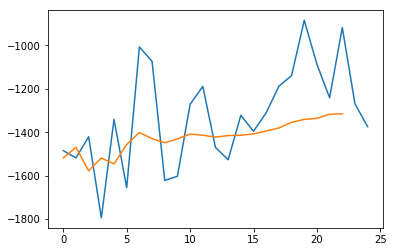

Episode 30, Reward: -863.208, Steps: 200, Final noise scale:   0.296
Episode 40, Reward: -137.573, Steps: 200, Final noise scale:   0.268
Episode 50, Reward: -393.641, Steps: 200, Final noise scale:   0.242


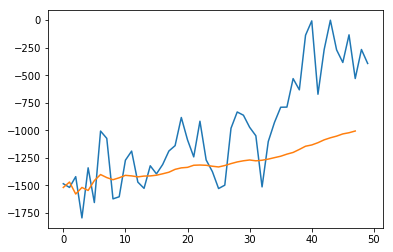

Episode 60, Reward: -267.344, Steps: 200, Final noise scale:   0.219
Episode 70, Reward: -263.327, Steps: 200, Final noise scale:   0.198


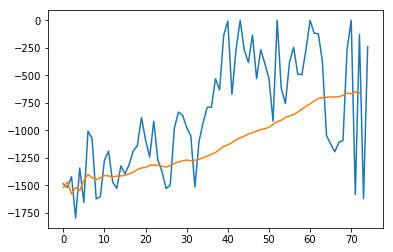

Episode 80, Reward: -121.600, Steps: 200, Final noise scale:   0.179
Episode 90, Reward: -219.550, Steps: 200, Final noise scale:   0.162
Episode 100, Reward: -118.816, Steps: 200, Final noise scale:   0.146


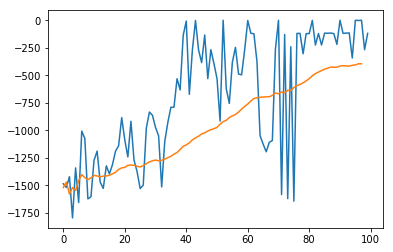

Episode 110, Reward: -240.355, Steps: 200, Final noise scale:   0.132
Episode 120, Reward: -125.325, Steps: 200, Final noise scale:   0.120


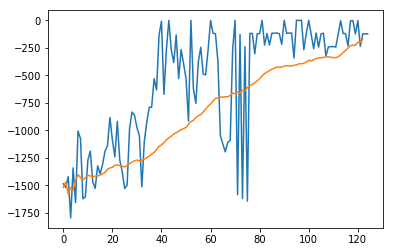

Episode 130, Reward: -1407.129, Steps: 200, Final noise scale:   0.108


KeyboardInterrupt: 

In [51]:
import os
os.chdir("../DDPG/")
import tensorflow as tf
from Agent import Agent

tf.reset_default_graph()
with tf.Session() as sess:

    agent = Agent(sess)
    agent.run()
    agent.play(1)
    agent.close()

### Notes
PER

## Rainbow DQN

### Concept

### Implementation

### Results

### Notes

## Conclusion